In [1]:
import sys
sys.path.append('../utils/')

from query import query_dataframe_f, pprint_query, nbprint_and_query
use_latex = False

# Question 4

In [2]:
q4_data = nbprint_and_query('Q4.sql')
q4_data.to_csv('q4_data.csv')

In [3]:
import pandas as pd
from datetime import datetime, timedelta

from trading_days import TradingDay

# Code run before this to retrieve data:
#q2a_data = nbprint_and_query('Q2a.sql')
#q2a_data.to_csv('q2a_data.csv')

q4_data = pd.read_csv('q4_data.csv',
                      parse_dates=['Date', 'Expiration'],
                      index_col=0)
q4_data['AdjStrike'] = q4_data['Strike'] / 1000.
# Expirations in IVY are on Saturdays, we need to compensate
#to the most recent trading day.
q4_data['ActualExpiration'] = q4_data['Expiration'] - TradingDay(1)

/usr/lib/python3/dist-packages/pandas/tseries/index.py:755: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning)


In [4]:
from datetime import datetime, timedelta
from itertools import chain
# Now, we've actually retrieved too much data.
# We first want to filter down to things that are
# actually +/- 10 trading days of an expiration.
# First, get all trading days, then build out all possible
# days, then filter where date is in that list of possible days.
def flatmap(f, items):
    return list(chain.from_iterable(map(f, items)))

def trading_window(date):
    n = 10
    starting_date = -TradingDay(n) + date
    return [starting_date + TradingDay(i)
            for i in range(n*2+1)]

trading_days = flatmap(trading_window,
                       q4_data['ActualExpiration'].unique())

q4_valid_data = q4_data[q4_data['Date'].isin(trading_days)]
q4_valid_data.head()

,Ticker,ClosePrice,Date,Strike,Expiration,StrikeDiff,AdjStrike,ActualExpiration
0,GLD,146.539993,2011-05-11,150000,2011-05-21,3.460007,150,2011-05-20
1,GLD,158.348007,2013-02-14,161000,2013-02-01,2.651993,161,2013-01-31
2,GLD,163.089996,2013-01-18,162000,2013-01-25,1.089996,162,2013-01-24
3,USO,30.698999,2012-06-11,35000,2012-06-01,4.301001,35,2012-05-31
4,USO,38.180000,2011-02-02,38000,2011-01-28,0.180000,38,2011-01-27


In [5]:
# Now comes the fun part. Currently we have all strikes,
# and we essentially want to filter this down to only ATM strikes.
from datetime import timedelta
def find_atm_strike(df):
    # Expiration is marked as a Saturday in Ivy, so we need to 
    prices = df[df['ActualExpiration'] == df['Date']]
    prices['Diff'] = (prices['AdjStrike'] -
                      prices['ClosePrice']).abs()
    # And get the strike with minimum difference from close
    # We first sort ordering smallest difference first, get the first row
    # (i.e. minimum) and then its actual value
    try:
        atm_strike = (prices.sort_values('Diff')
                      .head(1)['AdjStrike'].values[0])
    except IndexError:
        atm_strike = 0
        
    return atm_strike

def filter_atm(df):
    return df[df['AdjStrike'] == find_atm_strike(df)]

q4_groups = q4_valid_data.groupby(['ActualExpiration', 'Ticker'])
q4_atm = q4_groups.apply(filter_atm)

q4_atm.reset_index(drop=True, inplace=True)

In [6]:
def bus_days_between(start, end):
    if start.date() == end.date():
        return 0
    elif start < end:
        return len(pd.date_range(start=start.date(),
                                 end=end.date(),
                                 closed='left',
                                 freq=TradingDay(1)))
    else:
        return -len(pd.date_range(start=end.date(),
                                  end=start.date(),
                                  closed='left',
                                  freq=TradingDay(1)))
    
q4_atm['DeltaExpiration'] = q4_atm.apply(
    lambda r: bus_days_between(r.Date, r.ActualExpiration),
    1)

In [7]:
import numpy as np

def did_pin(group):
    group['Pinned'] = np.abs(group['ClosePrice'] -
                             group['AdjStrike']) < .125
    return group

q4_pinned = q4_atm.groupby(['Ticker',
                            'ActualExpiration']).apply(did_pin)
q4_pinned.to_csv('q4_pinned.csv')

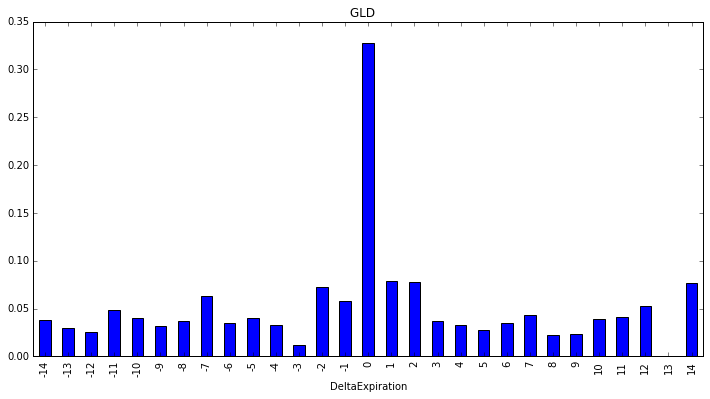

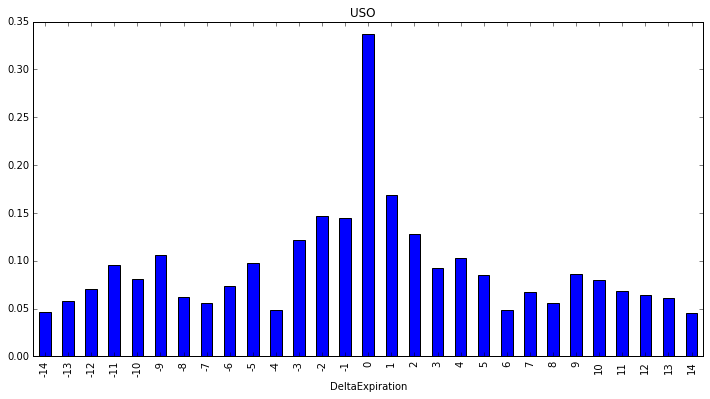

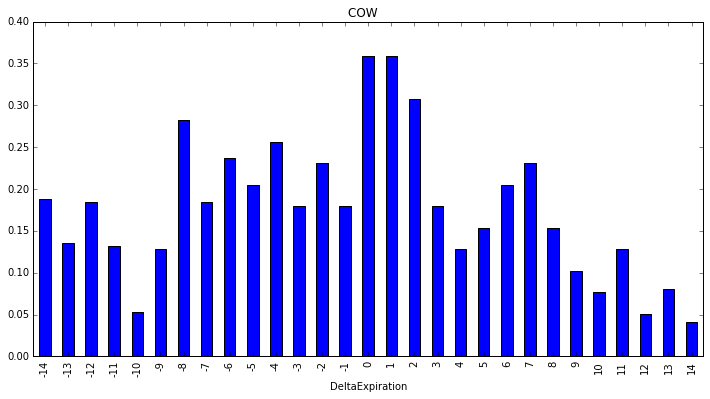

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
for ticker in q4_pinned['Ticker'].unique():
    plt.figure()
    plt.title(ticker)
    plt.gcf().set_size_inches(12, 6)
    (q4_pinned[q4_pinned['Ticker'] == ticker]
     .groupby(['DeltaExpiration']).mean()['Pinned']
     .plot(kind='bar'))